In [1]:
import MLJ
import DataFrames as DF
import CSV
using DataFramesMeta
using StatsPlots

In [2]:
include("PreprocessAerosolData.jl")
include("ActivationEmulatorModels.jl")

┌ Error: cuDNN is not available for your platform (x86_64-w64-mingw32-libgfortran5-cxx11-cuda+none-julia_version+1.8.5)
└ @ cuDNN C:\Users\mikha\.julia\packages\cuDNN\orKDE\src\cuDNN.jl:160


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\mikha\.julia\packages\MLJModels\Ft0z9\src\loading.jl:159


import MLJModels ✔
import EvoTrees

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\mikha\.julia\packages\MLJModels\Ft0z9\src\loading.jl:159


 ✔
import MLJFlux ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\mikha\.julia\packages\MLJModels\Ft0z9\src\loading.jl:159


NNModel (generic function with 1 method)

In [3]:
mach = MLJ.machine("emulators/nn_machine2.jls")

trained Machine; does not cache data
  model: DeterministicPipeline(f = preprocess_aerosol_data, …)
  args: 


In [4]:
X_test, Y_test = read_aerosol_dataset("datasets/dataset13_test.csv", true)

(3928×7 DataFrame
  Row │ mode_N   mode_mean  mode_stdev  mode_kappa  velocity   initial_tempera ⋯
      │ Float64  Float64    Float64     Float64     Float64    Float64         ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │  2.49e8    7.77e-9     1.91827   0.424793   0.896031               262 ⋯
    2 │  1.17e7    3.97e-6     1.91976   1.02334    0.0334789              271
    3 │  8.3e7     3.66e-9     1.55905   0.210819   0.0261734              298
    4 │  1.67e8    2.17e-7     1.75234   0.615909   2.89407                267
    5 │  1.98e7    8.66e-9     1.51527   0.631715   0.0476275              280 ⋯
    6 │  1.01e9    6.48e-9     1.96398   0.39116    0.406513               307
    7 │  1.52e8    5.76e-7     1.95671   0.461177   1.49929                288
    8 │  1.28e7    4.67e-7     1.60017   0.485603   2.85302                283
  ⋮   │    ⋮         ⋮          ⋮           ⋮           ⋮               ⋮      ⋱
 3922 │  1.35e9    3.8

In [5]:
pred = MLJ.predict(mach, X_test).act_frac_S

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(8 => 50, relu)
│   summary(x) = 8×1 Matrix{Float64}
└ @ Flux C:\Users\mikha\.julia\packages\Flux\n3cOc\src\layers\stateless.jl:60


3928-element view(adjoint(::Matrix{Float32}), :, 1) with eltype Float32:
 0.22162592
 0.99583995
 0.00016798094
 0.99956316
 0.04748726
 0.022817425
 0.9992741
 0.99999475
 0.9999887
 0.99983
 ⋮
 0.1154675
 0.16783997
 0.5920915
 0.18464608
 0.10079101
 0.0014191733
 0.00022283089
 0.9615141
 0.28286478

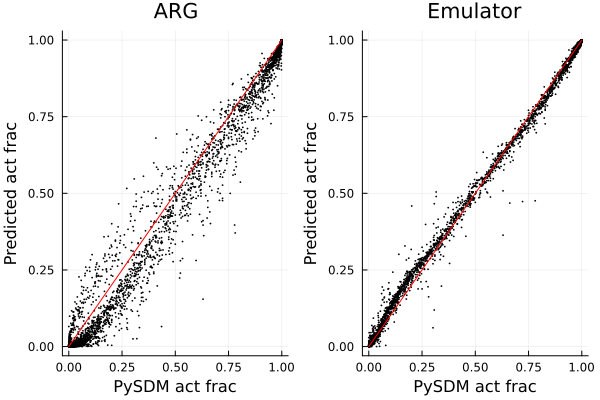

In [9]:
p1 = scatter(Y_test.act_frac_S, preprocess_aerosol_data(X_test).ARG_act_frac, color=:black, markersize=1,
            markerstrokewidth=0, label=nothing, title="ARG", xlabel="PySDM act frac", ylabel="Predicted act frac")
plot!([0, 1], [0, 1], color=:red, label=nothing)
p2 = scatter(Y_test.act_frac_S, pred, color=:black, markersize=1, markerstrokewidth=0, label=nothing,
            title="Emulator", xlabel="PySDM act frac", ylabel="Predicted act frac")
plot!([0, 1], [0, 1], color=:red, label=nothing)
plot(p1, p2)

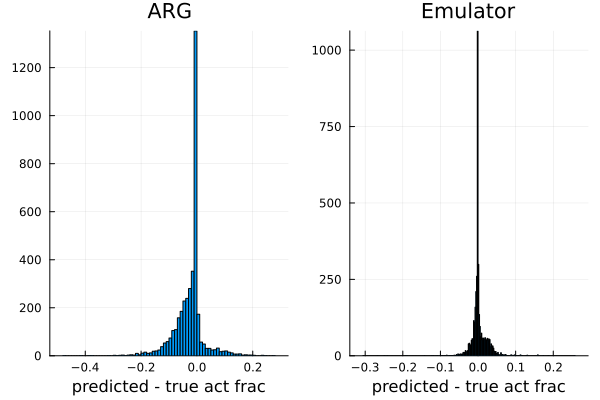

In [7]:
p1 = histogram(preprocess_aerosol_data(X_test).ARG_act_frac - Y_test.act_frac_S, label=nothing, xlabel="predicted - true act frac", title="ARG")
p2 = histogram(pred - Y_test.act_frac_S, label=nothing, xlabel="predicted - true act frac", title="Emulator")
plot(p1, p2)